In [1]:
import tqdm
import numpy
import pandas
import scipy.spatial
import matplotlib.pyplot

In [2]:
# hyperparameters used only when convergence method is 'best_chr'
BEST_CHROMOSOME_CONVERGENCE_LIMIT = 10
BEST_CHROMOSOME_CONVERGENCE_COUNTER = 0

In [3]:
# hyperparameters used only when convergence method is 'percentage'
PERCENTAGE_CHROMOSOME_CONVERGENCE_LIMIT = 1e-2

In [4]:
def initialize_hyperparameters():
    MUTATION_PROBABILITY = 0.2
    CROSSOVER_PROBABILITY = 0.9
    POPULATION_SIZE = 20
    # if K_NEIGHBORS is an odd number, then the algorithm might not work
    K_NEIGHBORS = 10
    GENERATIONS = 10000
    # options are: 'roulette wheel', 'rank', 'tournament'
    SELECTION_METHOD = 'tournament'
    # options are: 'single point', 'multiple point', 'uniform point', 'OX', 'PMX'
    CROSSOVER_METHOD = 'multiple point'
    # options are: 'random', 'elitism' for the first value, and 'gauss', 'reset' for the second 
    MUTATION_METHOD = ['elitism', 'gauss']
    # options are: 'binary', 'decimal', 'bucket'
    # TODO: Code 'binary' and 'bucket' encoding
    ENCODING_METHOD = 'decimal'
    # options are: 'best_chr', 'percentage', 'generation'
    CONVERGENCE_METHOD = 'generation'
    return MUTATION_PROBABILITY, CROSSOVER_PROBABILITY, POPULATION_SIZE, GENERATIONS, SELECTION_METHOD, CROSSOVER_METHOD, MUTATION_METHOD, K_NEIGHBORS, ENCODING_METHOD, CONVERGENCE_METHOD

In [5]:
def import_data():
    input_df = pandas.read_csv('u.data', encoding='utf-8', delimiter='\t', engine='python')
    input_df.columns = ['userid', 'movieid', 'ratings', 'timestamp']
    input_df = input_df.drop(columns='timestamp')
    tabular_df_raw = input_df.pivot(index='userid', columns='movieid', values='ratings')
    tabular_df = tabular_df_raw.fillna(0)
    tabular_np = tabular_df.to_numpy()
    return tabular_df, tabular_np

In [6]:
def fetch_user_vector(user, tabular_np):
    user_vector = tabular_np[user][tabular_np[user] != 0]
    user_indeces = numpy.where(tabular_np[user] > 0)
    return user_vector.astype(int), user_indeces

In [7]:
def evaluate_chromosome(chromosome, optim):
    # pearson's correlation metric
#     return numpy.corrcoef(chromosome, optim)[0, 1]
    # cosine similarity metric
#     return 1 - scipy.spatial.distance.cosine(optim, chromosome)
    # mse metric
#     return 10 - (numpy.square(optim - chromosome)).mean(axis=None)
    # number of common elements between chromosomes
    return len(numpy.where(chromosome == optim)[0])

In [8]:
def fetch_neighborhood(user, tabular_np, k):
    user_vector, user_indeces = fetch_user_vector(user, tabular_np)
    data_vector = numpy.take(tabular_np, user_indeces, axis=1).astype(numpy.int64)
    neighbors_data = numpy.zeros(k, dtype=numpy.float64)
    neighbors_indeces = numpy.zeros(k, dtype=int)
    for i in range(data_vector.shape[0]):
        if i != user:
            pearson = evaluate_chromosome(data_vector[i][0], user_vector)
            # check if the given vectors have the same non-zero indeces
            if numpy.where(user_vector > 0)[0].shape[0] == numpy.where(data_vector[i][0] > 0)[0].shape[0]:
                if numpy.where(user_vector > 0)[0] == numpy.where(data_vector[i][0] > 0)[0]:
                    # adjust pearson coefficient to minimum for we do not want that vector to be chosen
                    pearson = -2
                    print('Warning [2]: Same indeces are evaluated [at fetch neighborhood]')
            # sort pearson correlation coefficients
            for a in range(k):
                for b in range(k):
                    if neighbors_data[a] < neighbors_data[b]:
                        tmp = neighbors_data[b]
                        neighbors_data[b] = neighbors_data[a]
                        neighbors_data[a] = tmp
                        tmp = neighbors_indeces[b]
                        neighbors_indeces[b] = neighbors_indeces[a]
                        neighbors_indeces[a] = tmp
            # check if greater pearson coefficient was found
            for j in range(k):
                if neighbors_data[j] < pearson:
                    neighbors_data[j] = pearson
                    neighbors_indeces[j] = i
                    break
    return neighbors_data, neighbors_indeces

In [9]:
def fetch_optim(user, tabular_np, neighbors_indeces):
    optim_indeces = numpy.where(tabular_np[user] == 0)[0]
    for i in neighbors_indeces:
        optim_indeces = numpy.unique(numpy.concatenate((optim_indeces, numpy.where(tabular_np[i] > 0)[0]), 0))
    optim_values = numpy.take(tabular_np, optim_indeces, axis=1)
    return optim_values, optim_indeces

In [10]:
# function that converts parent indeces to the actual population: returns parent pairs [for 10 neighbors: outputs matrix(2x5)]
def index_to_chromosome_decode(idx, population):
    # reshape indeces to handle them easier [with population size = 10, idx is reshaped to: matrix(5,2)]
    idx = idx.reshape(int(population.shape[0]/2), 2)
    # define the generation population
    generation = None
    # convert given indeces to chromosomes 
    for i in range(int(population.shape[0]/2)):
        # extract 2 indeces
        X, Y = population[idx[i]]
        # stack the chromosomes
        if i == 0:
            # if loop run for first time, then initialize the generation population
            generation = numpy.stack((X, Y))
        else:
            # after first time, stack chromosomes to the generation population
            generation = numpy.vstack((generation, numpy.stack((X, Y))))
    # reshape matrix
    population = numpy.zeros((int(generation.shape[0]/2), 2, generation[0].shape[0]), dtype=numpy.int64)
    for i in range(population.shape[0]):
        for j in range(population.shape[1]):
            population[i][j] = generation[i * 2 + j]
    return population

In [11]:
def roulette_wheel_selection(population, optim):
    # initialize random sequence
    SEQUENCE = numpy.random.uniform(0, 1, population.shape[0])
    # get pearsons
    pearsons = numpy.zeros((population.shape[0]), dtype=numpy.float64)
    # we will add 1 to each value to get positive values and then sum them up to form the roulette
    pearsons = numpy.fromiter((evaluate_chromosome(population[i], optim) for i in range(population.shape[0])), pearsons.dtype) + 1
    roulette = pearsons / pearsons.sum()
    # get parents
    parents = numpy.zeros(population.shape[0], dtype=numpy.int64)
    for i in range(population.shape[0]):
        for c, j in enumerate(roulette):
            if roulette[ : c + 1].sum() >= SEQUENCE[i]:
                parents[i] = c
                break
    return index_to_chromosome_decode(parents, population)

In [12]:
def rank_selection(population, optim):
    # define evaluation vector
    pearsons = numpy.zeros((population.shape[0]), dtype=numpy.float64)
    # get all chromosome evaluations
    pearsons = numpy.fromiter((evaluate_chromosome(population[i], optim) for i in range(population.shape[0])), pearsons.dtype)
    # define ranks values vector
    rank_vals = numpy.zeros(population.shape[0])
    # define ranks indeces vector
    rank_indx = numpy.zeros(population.shape[0], dtype=numpy.int64)
    # define rank based probabilities vector
    probabilities = numpy.zeros(population.shape[0], dtype=numpy.int64)
    # deploy rank selection algorithm
    for p_counter, j in enumerate(pearsons):
        for r_counter, k in enumerate(rank_vals):
            # check if rank is lower than evaluation
            if j > k:
                rank_vals[r_counter] = j
                rank_indx[r_counter] = p_counter
            # sort ranks values and indeces
            for sort_i_indx, i_val in enumerate(rank_vals):
                for sort_j_indx, j_val in enumerate(rank_vals):
                    if i_val > j_val:
                        tmp = j_val
                        rank_vals[sort_j_indx] = i_val
                        rank_vals[sort_i_indx] = tmp
                        tmp = rank_indx[sort_j_indx]
                        rank_indx[sort_j_indx] = rank_indx[sort_i_indx]
                        rank_indx[sort_i_indx] = tmp
    return index_to_chromosome_decode(rank_indx, population)

In [13]:
def tournament_selection(population, optim):
    # initialize random sequence
    SEQUENCE = numpy.random.uniform(0, 1, population.shape[0])
    # get pearsons
    pearsons = numpy.zeros((population.shape[0]), dtype=numpy.int64)
    pearsons = numpy.fromiter((evaluate_chromosome(population[i], optim) for i in range(population.shape[0])), pearsons.dtype)
    # get parents
    parents = numpy.zeros(population.shape[0], dtype=numpy.int64)
    for i in range(population.shape[0]):
        k = numpy.ceil(SEQUENCE[i] * 10).astype(numpy.int64)
        chromosome_pointers = numpy.random.choice(numpy.arange(population.shape[0]), k)
        evaluation = pearsons[chromosome_pointers].max()
        if len(numpy.where(pearsons == evaluation)[0]) > 1:
            parents[i] = numpy.where(pearsons == evaluation)[0][0]
        else:
            parents[i] = numpy.where(pearsons == evaluation)[0]
    return index_to_chromosome_decode(parents, population)

In [14]:
def select_chromosomes(selection_method, population, optim):
    parent_pairs = None
    if selection_method == 'roulette wheel':
        parent_pairs = roulette_wheel_selection(population, optim)
    elif selection_method == 'rank':
        parent_pairs = rank_selection(population, optim)
    elif selection_method == 'tournament':
        parent_pairs = tournament_selection(population, optim)
    else:
        print('Error [1]: Invalid selection method\nExiting...')
        exit()
    return parent_pairs

In [15]:
def single_point_crossover(parent_pairs, x_probability):
    # define random probability sequence
    SEQUENCE = numpy.random.uniform(0, 1, parent_pairs.shape[0])
    # define new generation population variable
    population_hat = None
    # perform single point crossover 
    for i in range(parent_pairs.shape[0]):
        X, Y = parent_pairs[i]
        # check chromosomes' compatibility in case there is an error
        compatible_chromosomes = X.shape == Y.shape
        # define max index boundary
        chromosome_shape = X.shape[0]
        # initialize new chromosome
        a, b = numpy.zeros((2, chromosome_shape), dtype=numpy.int64)
        if not compatible_chromosomes:
            print("Error [2]: Incompatible chromosomes (at: single point selection\nExiting...)")
            exit()
        else:
            # crossover random point
            x_idx = numpy.random.randint(0, chromosome_shape, 1)[0]
            # first child chromosome
            a = numpy.append(X[:x_idx], Y[x_idx:])
            # second child chromosome
            b = numpy.append(Y[:x_idx], X[x_idx:])
            # crossover with respect to the crossover probability
            if SEQUENCE[i] < x_probability:
                # append children to form the new population
                if i == 0:
                    # if loop run for first time, then initialize the generation population
                    population_hat = numpy.stack((a, b))
                else:
                    # after first time, stack chromosomes to the generation population
                    population_hat = numpy.vstack((population_hat, numpy.stack((a, b))))
            else:
                # append parents to the new population
                if i == 0:
                    # if loop run for first time, then initialize the generation population
                    population_hat = numpy.stack((X, Y))
                else:
                    # after first time, stack chromosomes to the generation population
                    population_hat = numpy.vstack((population_hat, numpy.stack((X, Y))))
    return population_hat

In [16]:
def multiple_point_crossover(parent_pairs, x_probability):
    # define random probability sequence
    SEQUENCE = numpy.random.uniform(0, 1, parent_pairs.shape[0])
    # define new generation population variable
    population_hat = None
    # perform single point crossover 
    for i in range(parent_pairs.shape[0]):
        X, Y = parent_pairs[i]
        # check chromosomes' compatibility in case there is an error
        compatible_chromosomes = X.shape == Y.shape
        # define max index boundary
        chromosome_shape = X.shape[0]
        # initialize new chromosome
        a, b = numpy.zeros((2, chromosome_shape), dtype=numpy.int64)
        if not compatible_chromosomes:
            print("Error [13]: Incompatible chromosomes (at: multiple point selection\nExiting...)")
            exit()
        else:
            # crossover random point
            x_idx, y_idx = numpy.sort(numpy.random.randint(0, chromosome_shape, 2))
            # first child chromosome
            a = numpy.concatenate((X[ :x_idx], Y[x_idx:y_idx], X[y_idx: ]))
            # second child chromosome
            b = numpy.concatenate((Y[ :x_idx], X[x_idx:y_idx], Y[y_idx: ]))
            # crossover with respect to the crossover probability
            if SEQUENCE[i] < x_probability:
                # append children to form the new population
                if i == 0:
                    # if loop run for first time, then initialize the generation population
                    population_hat = numpy.stack((a, b))
                else:
                    # after first time, stack chromosomes to the generation population
                    population_hat = numpy.vstack((population_hat, numpy.stack((a, b))))
            else:
                # append parents to the new population
                if i == 0:
                    # if loop run for first time, then initialize the generation population
                    population_hat = numpy.stack((X, Y))
                else:
                    # after first time, stack chromosomes to the generation population
                    population_hat = numpy.vstack((population_hat, numpy.stack((X, Y))))
    return population_hat

In [17]:
def uniform_crossover(parent_pairs, x_probability):
    # define random chromosome probability sequence (to decide randomly whether ot perform crossover or not)
    X_SEQUENCE = numpy.random.uniform(0, 1, parent_pairs.shape[0])
    # define random element probability sequence (for uniform crossover)
    U_SEQUENCE = numpy.random.uniform(0, 1, parent_pairs.shape[0] * parent_pairs.shape[1]).reshape(parent_pairs.shape[0], parent_pairs.shape[1])
    # define element probability crossover (for uniform crossover)
    CONST_PROB = 0.5
    # define new generation population variable
    population_hat = None
    # perform single point crossover 
    for i in range(parent_pairs.shape[0]):
        X, Y = parent_pairs[i]
        # check chromosomes' compatibility in case there is an error
        compatible_chromosomes = X.shape == Y.shape
        # define max index boundary
        chromosome_shape = X.shape[0]
        # initialize new chromosome
        a, b = numpy.zeros((2, chromosome_shape), dtype=numpy.int64)
        if not compatible_chromosomes:
            print("Error [14]: Incompatible chromosomes (at: multiple point selection)\nExiting...)")
            exit()
        else:
            # crossover with respect to the crosover probability
            if X_SEQUENCE[i] < x_probability:
                # create children
                for c, (k, l) in enumerate(zip(X, Y)):
                    # repeatedly toss a coin and check with respect to CONST_PROB
                    if CONST_PROB > U_SEQUENCE[i][c]:
                        # gene exchange
                        a[c] = l
                        b[c] = k
                    else:
                        # NO gene exchange
                        a[c] = k
                        b[c] = l
                # append children to form the new population
                if i == 0:
                    # if loop run for first time, then initialize the generation population
                    population_hat = numpy.stack((a, b))
                else:
                    # after first time, stack chromosomes to the generation population
                    population_hat = numpy.vstack((population_hat, numpy.stack((a, b))))
            else:
                # append parents to the new population
                if i == 0:
                    # if loop run for first time, then initialize the generation population
                    population_hat = numpy.stack((X, Y))
                else:
                    # after first time, stack chromosomes to the generation population
                    population_hat = numpy.vstack((population_hat, numpy.stack((X, Y))))
    return population_hat

In [18]:
def order_crossover(parent_pairs, x_probability, encoding):
    # check if OX can be applied
    if encoding != 'bucket':
        print("Error [5]: Order crossover cannot be applied - Incompatible encoding (at: order crossover\nExiting...)")
        exit()
    else:
        # TODO
        # build OX code
        return

In [19]:
def partially_mapped_crossover(parent_pairs, x_probability, encoding):
    # check if PMX can be applied
    if encoding != 'bucket':
        print("Error [6]: Parially mapped crossover cannot be applied - Incompatible encoding (at: parially mapped crossover\nExiting...)")
        exit()
    else:
        # TODO
        # build PMX code
        return

In [20]:
def crossover_chromosomes(x_probability, x_method, selection_method, population, optim, encoding):
    parent_pairs = select_chromosomes(selection_method, population, optim)
    population_hat = None
    if x_method == 'single point':
        population_hat = single_point_crossover(parent_pairs, x_probability)
    elif x_method == 'multiple point':
        population_hat = multiple_point_crossover(parent_pairs, x_probability)
    elif x_method == 'uniform point':
        population_hat = uniform_crossover(parent_pairs, x_probability)
    elif x_method == 'OX':
        population_hat = order_crossover(parent_pairs, x_probability, encoding)
    elif x_method == 'PMX':
        population_hat = partially_mapped_crossover(parent_pairs, x_probability, encoding)
    else:
        print('Error [4]: Invalid crossover method [at crossover chromosomes]\nExiting...')
        exit()
    # check crossover effect over current generation
    if numpy.array_equal(population, population_hat):
#         print('Warning [1]: No crossover change in population [at crossover chromosomes]')
        return population
    else:
        return population_hat

In [21]:
# returns index of elite chromosome
def get_elite_chromosome(population, optim):
    idx, val, max_eval = -1, None, 0
    for i in range(population.shape[0]):
        val = evaluate_chromosome(population[i], optim)
        if max_eval < val:
            idx = i
            max_eval = val
    if idx == -1:
        print('Error [11]: Invalid elite chromosome index [at get elite chromosome]\nExiting...')
        exit()
#     if max_eval < 0:
#         print('Warning [5]: Low pearson maximum correlation coefficient\n\t\t\t[at get elite chromosome]')
    return idx

In [22]:
def gauss_replacement(chromosome):
    # define number of genes
    idx_interval = chromosome.shape[0]
    # generate random gaussian distribution
    GAUSSIAN = numpy.random.normal(loc=3, scale=2.0, size=chromosome.shape[0]).astype(numpy.int64)
    # fix lower numbers
    GAUSSIAN[GAUSSIAN < 1] = 1
    # fix higher numbers
    GAUSSIAN[GAUSSIAN > 5] = 5
    # define mutated array
    mutated_chromosome = numpy.zeros(idx_interval, dtype=numpy.int64)
    # define random generator for gene mutation decision
    SEQUENCE = numpy.random.uniform(0, 1, idx_interval)
    for i in range(idx_interval):
        # mutate gene with respect to current SEQUENCE probability
        if SEQUENCE[i] > 0.5:
            # probability valid, MUTATE
            mutated_chromosome[i] = GAUSSIAN[i]
        else:
            # probability inadequate, NO MUTATION
            mutated_chromosome[i] = chromosome[i]
    return mutated_chromosome

In [23]:
def reset_replacement(chromosome):
    # define number of genes
    idx_interval = chromosome.shape[0]
    # define mutated array
    mutated_chromosome = numpy.zeros(idx_interval, dtype=numpy.int64)
    # define random generator
    SEQUENCE = numpy.random.uniform(0, 1, idx_interval)
    for i in range(idx_interval):
        # mutate gene with respect to current SEQUENCE probability
        if SEQUENCE[i] > 0.5:
             # probability valid, MUTATE
            mutated_chromosome[i] = numpy.random.randint(1, 6, 1)
        else:
             # probability inadequate, NO MUTATION
            mutated_chromosome[i] = chromosome[i]
    return mutated_chromosome

In [24]:
def elitism(population, m_probability, m_method, optim):
    SEQUENCE = numpy.random.uniform(0, 1, population.shape[0])
    mutated_population, mutated_chromosome = None, None
    elite_chromosome_idx = get_elite_chromosome(population, optim)
    for i in range(population.shape[0]):
        chromosome = population[i]
        if SEQUENCE[i] < m_probability and i != elite_chromosome_idx:
            # mutate chromosome
            if m_method[1] == 'gauss':
                mutated_chromosome = gauss_replacement(chromosome)
            elif m_method[1] == 'reset':
                mutated_chromosome = reset_replacement(chromosome)
            else:
                print('Error [7]: Invalid mutation method combination [at elitism]\nExiting...')
                exit()
            # append chromosomes to the mutated population
            if i == 0:
                # if loop run for first time, then initialize the generation population
                mutated_population = mutated_chromosome
            else:
                # after first time, stack chromosomes to the generation population
                mutated_population = numpy.vstack((mutated_population, mutated_chromosome))
        else:
            # NO mutation
            # append chromosomes to the mutated population
            if i == 0:
                # if loop run for first time, then initialize the generation population
                mutated_population = chromosome
            else:
                # after first time, stack chromosomes to the generation population
                mutated_population = numpy.vstack((mutated_population, chromosome))
    return mutated_population

In [25]:
def random_mutation(population, m_probability, m_method):
    SEQUENCE = numpy.random.uniform(0, 1, population.shape[0])
    mutated_population, mutated_chromosome = None, None
    for i in range(population.shape[0]):
        chromosome = population[i]
        if SEQUENCE[i] < m_probability:
            # mutate chromosome
            if m_method[1] == 'gauss':
                mutated_chromosome = gauss_replacement(chromosome)
            elif m_method[1] == 'reset':
                mutated_chromosome = reset_replacement(chromosome)
            else:
                print('Error [8]: Invalid mutation method combination [at random mutation]\nExiting...')
                exit()
            # append chromosomes to the mutated population
            if i == 0:
                # if loop run for first time, then initialize the generation population
                mutated_population = mutated_chromosome
            else:
                # after first time, stack chromosomes to the generation population
                mutated_population = numpy.vstack((mutated_population, mutated_chromosome))
        else:
            # NO mutation
            # append chromosomes to the mutated population
            if i == 0:
                # if loop run for first time, then initialize the generation population
                mutated_population = chromosome
            else:
                # after first time, stack chromosomes to the generation population
                mutated_population = numpy.vstack((mutated_population, chromosome))
    return mutated_population

In [26]:
def mutate_chromosomes(probability, m_method, population, optim):
    population_hat = None
    if m_method[0] == 'random':
        population_hat = random_mutation(population, probability, m_method)
    elif m_method[0] == 'elitism':
        population_hat = elitism(population, probability, m_method, optim)
    else:
        print('Error [10]: Invalid mutation method [at mutate chromosomes]\nExiting...')
        exit()
    # check mutation effect over current generation
    if numpy.array_equal(population, population_hat):
#         print('Warning [3]: No mutation change in population [at mutate chromosomes]')
        return population
    else:
        return population_hat

In [27]:
def evaluate_best_chromosome(population, optim):
    idx_val = population.shape[0]
    pearsons_vector = numpy.zeros(idx_val, dtype=numpy.float64)
    for i in range(idx_val):
        pearsons_vector[i] = evaluate_chromosome(population[i], optim)
    evaluation = pearsons_vector.max()
    # return best chromosome evaluation
    return evaluation

In [28]:
def evaluate_generation(population, optim):
    idx_val = population.shape[0]
    pearsons_vector = numpy.zeros(idx_val, dtype=numpy.float64)
    for i in range(idx_val):
        pearsons_vector[i] = evaluate_chromosome(population[i], optim)
    evaluation = pearsons_vector.mean()
    # return generation evaluation
    return evaluation

In [29]:
def genetic_algorithm_convergence(evaluation, gen, conv_method, population, optim):
    stop = False
    if conv_method == 'best_chr':
        gen_eval = evaluate_best_chromosome(population, optim)
        evaluation[gen] = gen_eval
        if evaluation[gen] == evaluation[gen - 1]:
            BEST_CHROMOSOME_CONVERGENCE_COUNTER += 1
            if BEST_CHROMOSOME_CONVERGENCE_COUNTER > BEST_CHROMOSOME_CONVERGENCE_LIMIT:
                stop = True
    elif conv_method == 'percentage':
        gen_eval = evaluate_generation(population, optim)
        evaluation[gen] = gen_eval
        if numpy.abs(evaluation[gen] - evaluation[gen - 1]) < PERCENTAGE_CHROMOSOME_CONVERGENCE_LIMIT:
            stop = True
    elif conv_method == 'generation':
        if gen == 0:
            print('Warning [4]: Algorithm does not perform early stopping [at genetic algorithm convergence]')
    else:
        print('Error [9]: Invalid mutation method [at mutate chromosomes]\nExiting...')
        exit()
    return stop, evaluation

In [30]:
def save_population(user, population, optim):
    # save population and optim chromosome using as prefix the user id
    numpy.savetxt("user_" + str(user) + "-optim.txt", optim.astype(int), fmt='%i', delimiter="\t")
    numpy.savetxt("user_" + str(user) + "-population.txt", population.astype(int), fmt='%i', delimiter="\t")
    return

In [38]:
def save_evaluations(user, population, optim):
    # define pearson correlation coefficient vector
    pearsons = numpy.zeros(population.shape[0], dtype=numpy.float64)
    # define mse vector
    mse = numpy.zeros(population.shape[0], dtype=numpy.float64)
    # define common gene counter vector
    common_genes = numpy.zeros(population.shape[0], dtype=numpy.int64)
    # define cosine similarity vector
    cosines = numpy.zeros(population.shape[0], dtype=numpy.float64)
    # compute vectors
    for i in range(population.shape[0]):
        pearsons[i] = numpy.corrcoef(population[i], optim)[0, 1]
        mse[i] = (numpy.square(optim - population[i])).mean(axis=None)
        common_genes[i] = evaluate_chromosome(population[i], optim)
        cosines[i] = 1 - scipy.spatial.distance.cosine(optim, population[i])
    # save vectors to txt files using as prefix the user id
    numpy.savetxt("user_" + str(user) + "-pearsons.txt", pearsons, delimiter="\t")
    numpy.savetxt("user_" + str(user) + "-mse.txt", mse, delimiter="\t")
    numpy.savetxt("user_" + str(user) + "-common_genes.txt", common_genes.astype(int), fmt='%i', delimiter="\t")
    numpy.savetxt("user_" + str(user) + "-cosines.txt", cosines, delimiter="\t")
    return

In [39]:
def fit_genetic_algorithm(M_PROBABILITY, X_PROBABILITY, P_SIZE, N_GEN, SEL_M, CROSS_M, MUT_METHOD, K, items, encoding, CONV_M):
    for user in tqdm.tqdm_notebook(range(items.shape[0])):
        # define evaluations list to plot afterwards
        U_EVALS_LIST = list()
        # fetch user's rating top - k neighbors (k=10)
        neighbors_data, neighbors_indeces = fetch_neighborhood(user, items, K)
        # fetch optimal solution vector
        optim_values, optim_indeces = fetch_optim(user, items, neighbors_indeces)
        # reformat optimal solution vector
        # trim non neighbor users
        optim_values = optim_values[neighbors_indeces]
        # drop zero values
        optim_mean = numpy.count_nonzero([optim_values], axis=1)
        # find mean of all k vectors and flatten optimal solution to a single vector
        optim_values = optim_values.sum(axis=0)
        optim_indeces = optim_indeces[optim_values != 0]
        optim_values = optim_values[optim_values != 0]
        optim_mean = optim_mean[optim_mean != 0]
        optim_values = optim_values / optim_mean
        # round up mean
        optim_values = numpy.ceil(optim_values).astype(numpy.int64)
        # random initialize population (chromosomes)
        chromosomes = numpy.random.choice(numpy.unique(optim_values), (P_SIZE, optim_values.shape[0]))
        # initialize error (evaluation) array
        evaluation = numpy.zeros(N_GEN)
        # initialize early stopping conditional
        stop = False
        # fit GA
        for gen in tqdm.tqdm_notebook(range(N_GEN)):
            # select and crossover population
            chromosomes = crossover_chromosomes(X_PROBABILITY, CROSS_M, SEL_M, chromosomes, optim_values, encoding)
            # mutate chromosomes
            chromosomes = mutate_chromosomes(M_PROBABILITY, MUT_METHOD, chromosomes, optim_values)
            # check GA convergence
            stop, evaluation = genetic_algorithm_convergence(evaluation, gen, CONV_M, chromosomes, optim_values)
            # if GA converges
            if stop is True:
                # save population
                save_population(user, chromosomes, optim_values)
                # save different fitness metrics
                save_evaluations(user, chromosomes, optim_values)
                # stop fitting
                break
            # custom convergence conditional: evaluate by chromosome accuracy [90% accuracy convergence]
            if numpy.mean(numpy.fromiter((evaluate_chromosome(chromosomes[i], optim_values) for i in range(chromosomes.shape[0])), numpy.int64)) / chromosomes[0].shape[0] > 0.9:
                # print population accuracy
                print("Mean accuracy: ", numpy.mean(numpy.fromiter((evaluate_chromosome(chromosomes[i], optim_values) for i in range(chromosomes.shape[0])), numpy.int64)), "\tTotal chromosomes: ", chromosomes[0].shape[0])
                # save population
                save_population(user, chromosomes, optim_values)
                # save different fitness metrics
                save_evaluations(user, chromosomes, optim_values)
                # stop fitting
                break
            # append mean population fitness
            U_EVALS_LIST.append(numpy.mean(numpy.fromiter((evaluate_chromosome(chromosomes[i], optim_values) for i in range(chromosomes.shape[0])), numpy.int64)))
        # save population
        save_population(user, chromosomes, optim_values)
        # save different fitness metrics
        save_evaluations(user, chromosomes, optim_values)
        # convert mean population fitness list to numpy array
        U_EVALS_ARRAY = numpy.asarray(U_EVALS_LIST)
        # define x axis of plot
        x_axis = numpy.arange(U_EVALS_ARRAY.shape[0])
        # plot mean population fitness array
        matplotlib.pyplot.plot(x_axis, U_EVALS_ARRAY, label="User " + str(user) + " - Evaluation")
        matplotlib.pyplot.legend()
#         matplotlib.pyplot.show()
        # save figure
        matplotlib.pyplot.savefig("user_" + str(user) + "-evaluation.png", bbox_inches='tight')

In [40]:
def main():
    # hyperparameter definition
    M_PROBABILITY, X_PROBABILITY, P_SIZE, N_GEN, SEL_M, CROSS_M, MUT_METHOD, K, ENC, CONV = initialize_hyperparameters()
    # GA fitting data
    tabular_df, tabular_np = import_data()
    # fit GA
    fit_genetic_algorithm(M_PROBABILITY, X_PROBABILITY, P_SIZE, N_GEN, SEL_M, CROSS_M, MUT_METHOD, K, tabular_np, ENC, CONV)

/home/andreas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/home/andreas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Warning [4]: Algorithm does not perform early stopping [at genetic algorithm convergence]



/home/andreas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Warning [4]: Algorithm does not perform early stopping [at genetic algorithm convergence]



/home/andreas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Warning [4]: Algorithm does not perform early stopping [at genetic algorithm convergence]



/home/andreas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Warning [4]: Algorithm does not perform early stopping [at genetic algorithm convergence]



KeyboardInterrupt: 

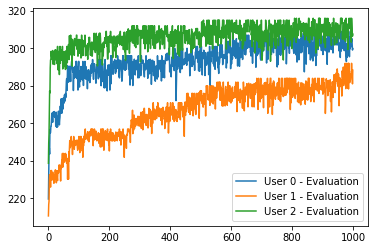

In [41]:
if __name__ == '__main__':
    main()